In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
from scipy import ndimage
from scipy.spatial import cKDTree

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

In [2]:
from damascus import sweep

In [3]:
merian_dir = '/Users/song/Downloads/wandering/'

sweep_name = os.path.join(merian_dir, 'sweep-000m045-010m040_psrc.fits')

In [155]:
sweep_test = sweep.SweepCatalog(sweep_name, suffix='_psrc', read_in=True)

In [156]:
sweep_data = sweep_test.data

In [157]:
radec_range = [sweep_test.ra_range, sweep_test.dec_range] 
radec_extent = [sweep_test.ra_min, sweep_test.ra_max, 
                sweep_test.dec_min, sweep_test.dec_max] 

In [158]:
psf_data = sweep_data[
    (sweep_data['FLAG'] == 1) & (sweep_data['MAG_G_DERED'] >= 20.0) & 
    (sweep_data['MAG_G_DERED'] - sweep_data['MAG_R_DERED'] <= 0.9)]
rex_data = sweep_data[
    (sweep_data['FLAG'] == 2) & (sweep_data['MAG_G_DERED'] >= 20.0) &
    (sweep_data['MAG_G_DERED'] - sweep_data['MAG_R_DERED'] <= 0.9)]

In [159]:
psf_hist, ra_edges, dec_edges = np.histogram2d(
    psf_data['RA'], psf_data['DEC'], range=radec_range, bins=[120, 120])

rex_hist, ra_edges, dec_edges = np.histogram2d(
    rex_data['RA'], rex_data['DEC'], range=radec_range, bins=[120, 120])

<ipython-input-160-8ea4b48b91f9>:23: RuntimeWarning: divide by zero encountered in true_divide
  (rex_hist / psf_hist).T, origin='lower', extent=radec_extent, aspect='auto', interpolation=None)


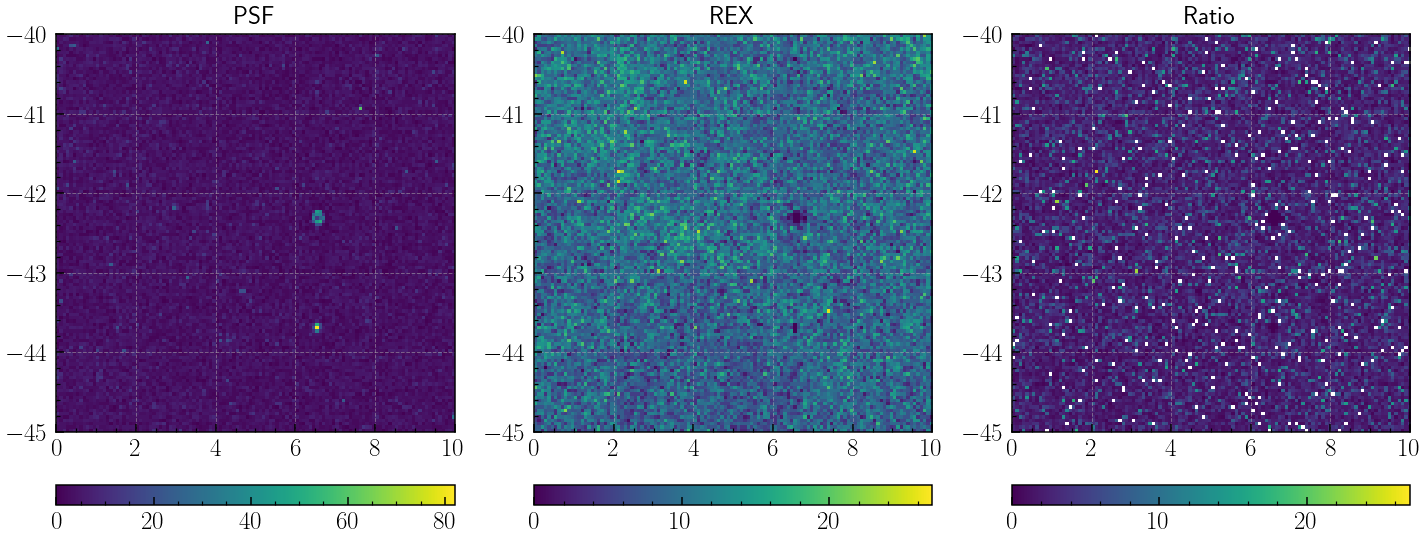

In [160]:
fig = plt.figure(figsize=(20, 8))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.94)

gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.2, hspace=0.10)

ax1 = plt.subplot(gs[0])
ax1.set_title('PSF', fontsize=25)

psf = ax1.imshow(psf_hist.T, origin='lower', extent=radec_extent, aspect='auto', interpolation=None)
fig.colorbar(psf, ax=ax1, orientation="horizontal", pad=0.1)

ax2 = plt.subplot(gs[1])
ax2.set_title('REX', fontsize=25)

rex = ax2.imshow(rex_hist.T, origin='lower', extent=radec_extent, aspect='auto', interpolation=None)
fig.colorbar(rex, ax=ax2, orientation="horizontal", pad=0.1)

ax3 = plt.subplot(gs[2])
ax3.set_title('Ratio', fontsize=25)

ratio = ax3.imshow(
    (rex_hist / psf_hist).T, origin='lower', extent=radec_extent, aspect='auto', interpolation=None)
fig.colorbar(ratio, ax=ax3, orientation="horizontal", pad=0.1)


In [129]:
fig.savefig(sweep_test.sweep_name.replace('.fits', '') + '.png', dpi=150)

In [4]:
psrc_hist = Table.read('/Users/song/Downloads/wandering/decals_dr9_psrc_hist.fits')
psrc_dense = Table.read('/Users/song/Downloads/wandering/decals_dr9_psrc_density.fits')

In [29]:
def summary_one_sweep(sweep, psf_min=0, psf_max=None, b_min=30):
    ra_cen, dec_cen = np.meshgrid(sweep['ra_cen'], sweep['dec_cen'])
    ra_flat, dec_flat = ra_cen.flatten(), dec_cen.flatten()
    
    psf_flat, rex_flat = sweep['psf'].T.flatten(), sweep['rex'].T.flatten()
    
    if psf_max is None:
        psf_max = np.max(psf_flat)
    
    gal_b = SkyCoord(
        ra=(ra_flat * u.degree), dec=(dec_flat * u.degree), frame='icrs'
    ).galactic.b.value
    
    mask = (psf_flat > psf_min) & (psf_flat <= psf_max) & (np.abs(gal_b) >= b_min)
    
    sweep_hist = Table()
    sweep_hist['ra'] = ra_flat[mask]
    sweep_hist['dec'] = dec_flat[mask]
    sweep_hist['psf'] = psf_flat[mask]
    sweep_hist['rex'] = rex_flat[mask]
    sweep_hist['b'] = gal_b[mask]
    
    return sweep_hist

In [31]:
dr9_hist = vstack(
    [summary_one_sweep(s, psf_min=10, psf_max=400, b_min=40) for s in psrc_hist])

print(len(dr9_hist))

512481


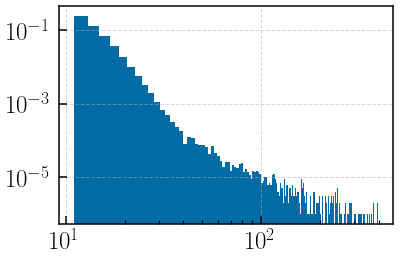

In [32]:
_ = plt.hist(dr9_hist['psf'], log=True, density=True, bins=200)

plt.xscale('log')

In [34]:
dr9_dense = vstack(
    [summary_one_sweep(s, psf_min=10, psf_max=100, b_min=40) for s in psrc_dense])

len(dr9_dense)

512481


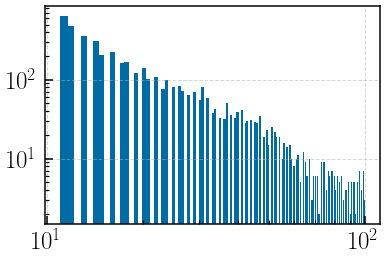

In [35]:
_ = plt.hist(dr9_dense['psf'], log=True, density=False, bins=150)

plt.xscale('log')

In [37]:
def show_ra_dec(cat):
    for obj in cat:
        print("{:9.5f} {:9.5f}".format(obj['ra'], obj['dec']))

In [42]:
mask = (dr9_dense['psf'] > 18) & (dr9_dense['psf'] <= 20)

if mask.sum() > 200:
    print("# Pick 200 from {:d}".format(mask.sum()))
    show_ra_dec(np.random.choice(dr9_dense[mask], 200, replace=False))
else:
    show_ra_dec(dr9_dense[mask])

# Pick 200 from 261
 39.82500 -34.34167
 40.19167 -34.34167
205.67500  28.32500
199.05833  17.67500
 40.17500 -34.32500
 39.79167 -34.40833
205.55833  28.50833
 16.32500   2.14167
 11.82500 -25.29167
151.37500   0.07500
152.24167  12.34167
 13.74167 -37.65833
 39.90833 -34.74167
 40.19167 -34.52500
 13.77500 -37.60833
 39.89167 -34.32500
229.59167   1.95833
 69.04167 -58.82500
 39.85833 -34.79167
343.15833   6.09167
 39.75833 -34.44167
 13.77500 -37.55833
 40.24167 -34.60833
 40.07500 -34.29167
229.62500   1.95833
205.59167  28.49167
 14.90833 -33.69167
 40.05833 -34.67500
 40.20833 -34.52500
 39.80833 -34.95833
 40.04167 -34.67500
 40.00833 -34.22500
198.32500  18.10833
 13.77500 -37.59167
 40.00833 -34.24167
 40.15833 -34.40833
 11.79167 -20.65833
 39.92500 -34.25833
198.35833  18.27500
 13.27500 -26.60833
 40.22500 -34.55833
166.42500  -0.02500
 39.84167 -34.40833
 40.19167 -34.30833
 11.77500 -20.80833
 13.54167 -37.65833
 40.07500 -34.70833
168.29167  22.17500
 15.00833 -33.72500
